# Interpretability via SHAP Values 

CPH 200C Problem 3

Questions? Ask Professor Irene Chen (iychen@berkeley.edu)

As machine learning models become more inscrutable, we are interested in methods to better understand why our models make the decisions they do --- and as a result whether we can trust them. To address this problem, we typically apply either post-hoc explanations to trained models or restrict our models to specific classes that are deemed more easily understandable. The goal of this section of the problem set is to familiarize you with the SHAP values package to apply interpretability methods to the diabetes dataset we have already explored.


## 0. Load packages

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import seaborn as sns

from matplotlib import pyplot as plt


fname = '/Users/hongzhouluan/Desktop/Cornerstone_200C_project3/data/diabetic_data.csv'

In [53]:
df = pd.read_csv(fname)

## 1. Clean Diabetes Dataset

Below please find some simple data cleaning. You may substitute if you prefer your data cleaning pipeline from Pset1

In [54]:
df['readmitted_bool'] = (df['readmitted'] == '<30')

In [55]:
df['max_glu_serum'] = df['max_glu_serum'].fillna('null')
df['A1Cresult'] = df['max_glu_serum'].fillna('null')

In [56]:
cat_cols = ['race', 'gender', 'age', 'weight',  'admission_type_id', 'discharge_disposition_id', 
            'admission_source_id', 'payer_code','medical_specialty','max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

val_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

cat_cols_all = []
df_all = []

for col in cat_cols:
    col_dummies = pd.get_dummies(df[col],col, drop_first=True)
    df_all.append(col_dummies)

cat_df = pd.concat(df_all,axis=1)

df['diag_1copy'] = df['diag_1'].copy()
counts = pd.value_counts(df['diag_1'])
mask = df['diag_1'].isin(counts[counts < 1000].index)
df['diag_1copy'][mask] = 'other'
diag_dummies = pd.get_dummies(df['diag_1copy'],drop_first=True)

diag_a1c = pd.get_dummies(df[['A1Cresult', 'diag_1copy']].apply(tuple, axis=1))
diag_a1c.columns = [i[0] + '_' + i[1] for i in diag_a1c.columns]


X = pd.concat([cat_df, diag_dummies, df[val_cols], diag_a1c], axis=1)
y = df['readmitted_bool']

/var/folders/5d/fz2jdmk530jfw8k__ywz47_r0000gn/T/ipykernel_80457/3328005027.py:24: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(df['diag_1'])
/var/folders/5d/fz2jdmk530jfw8k__ywz47_r0000gn/T/ipykernel_80457/3328005027.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diag_1copy'][mask] = 'other'


In [57]:
def clean(x):
    return x.replace('?', '').replace('<', 'less').replace('[','').replace(']','')

cols_clean = [clean(i) for i in X.columns]

X.columns = cols_clean

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test,train_size=0.5)

In [59]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc",use_label_encoder=False)

clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=5)
yhat = clf.predict_proba(X_test)[:,1]

/Users/hongzhouluan/opt/anaconda3/envs/cornerstoneproject/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.64432
[1]	validation_0-auc:0.65440
[2]	validation_0-auc:0.65951
[3]	validation_0-auc:0.66634
[4]	validation_0-auc:0.66678
[5]	validation_0-auc:0.66897
[6]	validation_0-auc:0.66922
[7]	validation_0-auc:0.67034
[8]	validation_0-auc:0.67046
[9]	validation_0-auc:0.67276
[10]	validation_0-auc:0.67347
[11]	validation_0-auc:0.67532
[12]	validation_0-auc:0.67490
[13]	validation_0-auc:0.67539
[14]	validation_0-auc:0.67651
[15]	validation_0-auc:0.67689
[16]	validation_0-auc:0.67855
[17]	validation_0-auc:0.67968
[18]	validation_0-auc:0.67872
[19]	validation_0-auc:0.67897
[20]	validation_0-auc:0.67903
[21]	validation_0-auc:0.67929
[22]	validation_0-auc:0.67890


## 2. SHAP Value Interpretability

Please fill in the `TODO` comments to produce two plots:
 1. **Data-point-level interpretability**: Which features are most important for predicting this data point?
 2. **Model-level interpretability**: Which features are most important for positive and negative predictions?
 
You may find [this page](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html) helpful.

In [12]:
import shap
shap.initjs()

/Users/hongzhouluan/opt/anaconda3/envs/cornerstoneproject/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)

In [ ]:
# TODO: create force plot for one data point illustrating the expected value and the shape values
# calculate the expected value
expected_value = explainer.expected_value
print(expected_value)

In [ ]:
import matplotlib.pyplot as plt

shap.plots.force(shap_values[0])
shap.plots.force(shap_values[0], matplotlib=True)
plt.savefig('/Users/hongzhouluan/Desktop/Cornerstone_200C_project3/plots/force_plot.png', bbox_inches='tight')
plt.close()

In [ ]:
# TODO: create summary plot of shape values for X_test
shap.summary_plot(shap_values, X_test)
plt.savefig('/Users/hongzhouluan/Desktop/Cornerstone_200C_project3/plots/summary_plot.png', bbox_inches='tight')

## Interpretability Methods

### Black box models: logistic regression, XGBoost, and NN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Logistic regression
bb_lr = LogisticRegression()
bb_lr.fit(X_train, y_train)
yhat_bb_lr = bb_lr.predict_proba(X_train)[:,1]
y_hat_bb_lr_test = bb_lr.predict_proba(X_test)[:,1]

# XGBoost
bb_xgb = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc",use_label_encoder=False)
bb_xgb.fit(X_train, y_train)
yhat_bb_xgb = bb_xgb.predict_proba(X_train)[:,1]
y_hat_bb_xgb_test = bb_xgb.predict_proba(X_test)[:,1]

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
class NN(pl.LightningModule):
    def __init__(self, num_features):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.view(-1, 1).float()
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def train_dataloader(self):
        dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train.astype(float)), torch.Tensor(y_train.astype(float)))
        return torch.utils.data.DataLoader(dataset, batch_size=32)
    
    def val_dataloader(self):
        dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test.astype(float)), torch.Tensor(y_test.astype(float)))
        return torch.utils.data.DataLoader(dataset, batch_size=32)

num_features = X_train.shape[1]
bb_nn = NN(num_features=num_features)
trainer = pl.Trainer(max_epochs=10, enable_checkpointing=False)
trainer.fit(bb_nn, bb_nn.train_dataloader())

X_train = X_train.astype(float)
X_test = X_test.astype(float)
yhat_nn = bb_nn(torch.Tensor(X_train)).detach().numpy().flatten()
y_hat_nn_test = bb_nn(torch.Tensor(X_test)).detach().numpy().flatten()

In [71]:
# find auc between yhat and y
auc_bb_lr = roc_auc_score(y_test, y_hat_bb_lr_test)
auc_bb_xgb = roc_auc_score(y_test, y_hat_bb_xgb_test)
auc_bb_nn = roc_auc_score(y_test, y_hat_nn_test)
print(f"AUC for Logistic Regression: {auc_bb_lr}")
print(f"AUC for XGBoost: {auc_bb_xgb}")
print(f"AUC for Neural Network: {auc_bb_nn}")

AUC for Logistic Regression: 0.6637471218110438
AUC for XGBoost: 0.6734238041809906
AUC for Neural Network: 0.6698747946270912


## MIMIC models: logistic regression and XGBoost

In [72]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression

################################################################################################################
# using xgb.XGBRegressor instead of xgb.XGBClassifier because the output of the black box model is continuous  #
# using LinearRegression instead of LogisticRegression because the output of the black box model is continuous #
################################################################################################################


def mimic_model_predict(X_train, X_test, bb_yhat, mimic_type):
    if mimic_type == 'lr':
        mimic_model = LinearRegression()
    elif mimic_type == 'xgb':
        mimic_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    mimic_model.fit(X_train, bb_yhat)
    yhat_mimic = mimic_model.predict(X_test)
    return yhat_mimic

def evaluate_mimic_model(X_train, X_test, bb_yhat, bb_type, mimic_type, y_test, y_hat_bb_test):
    yhat_mimic = mimic_model_predict(X_train, X_test, bb_yhat, mimic_type)
    auc = roc_auc_score(y_test, yhat_mimic)
    rmse = np.sqrt(mean_squared_error(y_hat_bb_test, yhat_mimic))
    print(f'AUC of {bb_type} bb and {mimic_type} mimic model: {auc:.4f}')
    print(f'RMSE between {bb_type} black box prediction and {mimic_type} mimic model prediction: {rmse:.4f}')
    return auc, rmse

# for example: for lr bb model and xgb mimic model
auc_lr_xgb, rmse_lr_xgb = evaluate_mimic_model(X_train, X_test, yhat_bb_lr, 'lr', 'xgb', y_test, y_hat_bb_lr_test)

AUC of lr bb and xgb mimic model: 0.6636
RMSE between lr black box prediction and xgb mimic model prediction: 0.0070


In [73]:
# grid: bb types: lr, xgb, nn; mimic types: lr, xgb
auc_lr_lr, rmse_lr_lr = evaluate_mimic_model(X_train, X_test, yhat_bb_lr, 'lr', 'lr', y_test, y_hat_bb_lr_test)
auc_lr_xgb, rmse_lr_xgb = evaluate_mimic_model(X_train, X_test, yhat_bb_lr, 'lr', 'xgb', y_test, y_hat_bb_lr_test)
auc_xgb_lr, rmse_xgb_lr = evaluate_mimic_model(X_train, X_test, yhat_bb_xgb, 'xgb', 'lr', y_test, y_hat_bb_xgb_test)
auc_xgb_xgb, rmse_xgb_xgb = evaluate_mimic_model(X_train, X_test, yhat_bb_xgb, 'xgb', 'xgb', y_test, y_hat_bb_xgb_test)
auc_nn_lr, rmse_nn_lr = evaluate_mimic_model(X_train, X_test, yhat_nn, 'nn', 'lr', y_test, y_hat_nn_test)
auc_nn_xgb, rmse_nn_xgb = evaluate_mimic_model(X_train, X_test, yhat_nn, 'nn', 'xgb', y_test, y_hat_nn_test)


AUC of lr bb and lr mimic model: 0.6683
RMSE between lr black box prediction and lr mimic model prediction: 0.0141
AUC of lr bb and xgb mimic model: 0.6636
RMSE between lr black box prediction and xgb mimic model prediction: 0.0070
AUC of xgb bb and lr mimic model: 0.6795
RMSE between xgb black box prediction and lr mimic model prediction: 0.0519
AUC of xgb bb and xgb mimic model: 0.6843
RMSE between xgb black box prediction and xgb mimic model prediction: 0.0365
AUC of nn bb and lr mimic model: 0.6692
RMSE between nn black box prediction and lr mimic model prediction: 0.0297
AUC of nn bb and xgb mimic model: 0.6759
RMSE between nn black box prediction and xgb mimic model prediction: 0.0222


In [75]:
# give me the largest and smallest value of yhat_bb_lr values and the variance of yhat_bb_lr values
max_yhat_bb_lr = np.max(yhat_bb_lr)
min_yhat_bb_lr = np.min(yhat_bb_lr)
var_yhat_bb_lr = np.var(yhat_bb_lr)
print(f'Maximum value of yhat_bb_lr: {max_yhat_bb_lr:.4f}')
print(f'Minimum value of yhat_bb_lr: {min_yhat_bb_lr:.4f}')
print(f'Variance of yhat_bb_lr: {var_yhat_bb_lr:.4f}')

Maximum value of yhat_bb_lr: 0.9513
Minimum value of yhat_bb_lr: 0.0261
Variance of yhat_bb_lr: 0.0037


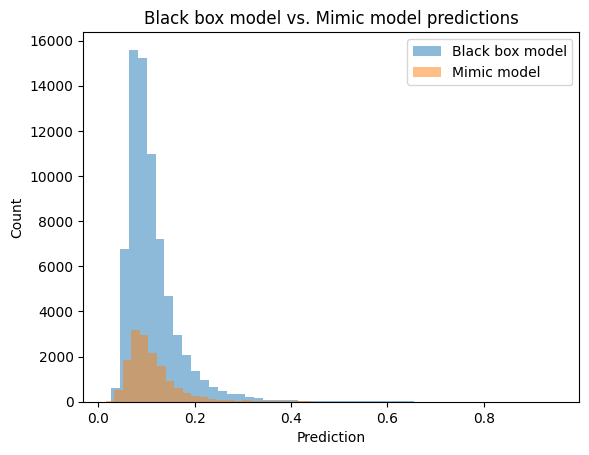

In [76]:
# plot values of yhat_bb_lr and yhat_mimic as histograms on top of each other
yhat_mimic = mimic_model_predict(X_train, X_test, yhat_bb_lr, 'xgb')
plt.hist(yhat_bb_lr, bins=50, alpha=0.5, label='Black box model')
plt.hist(yhat_mimic, bins=50, alpha=0.5, label='Mimic model')
plt.legend(loc='upper right')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Black box model vs. Mimic model predictions')
plt.show()

## Feature Importances

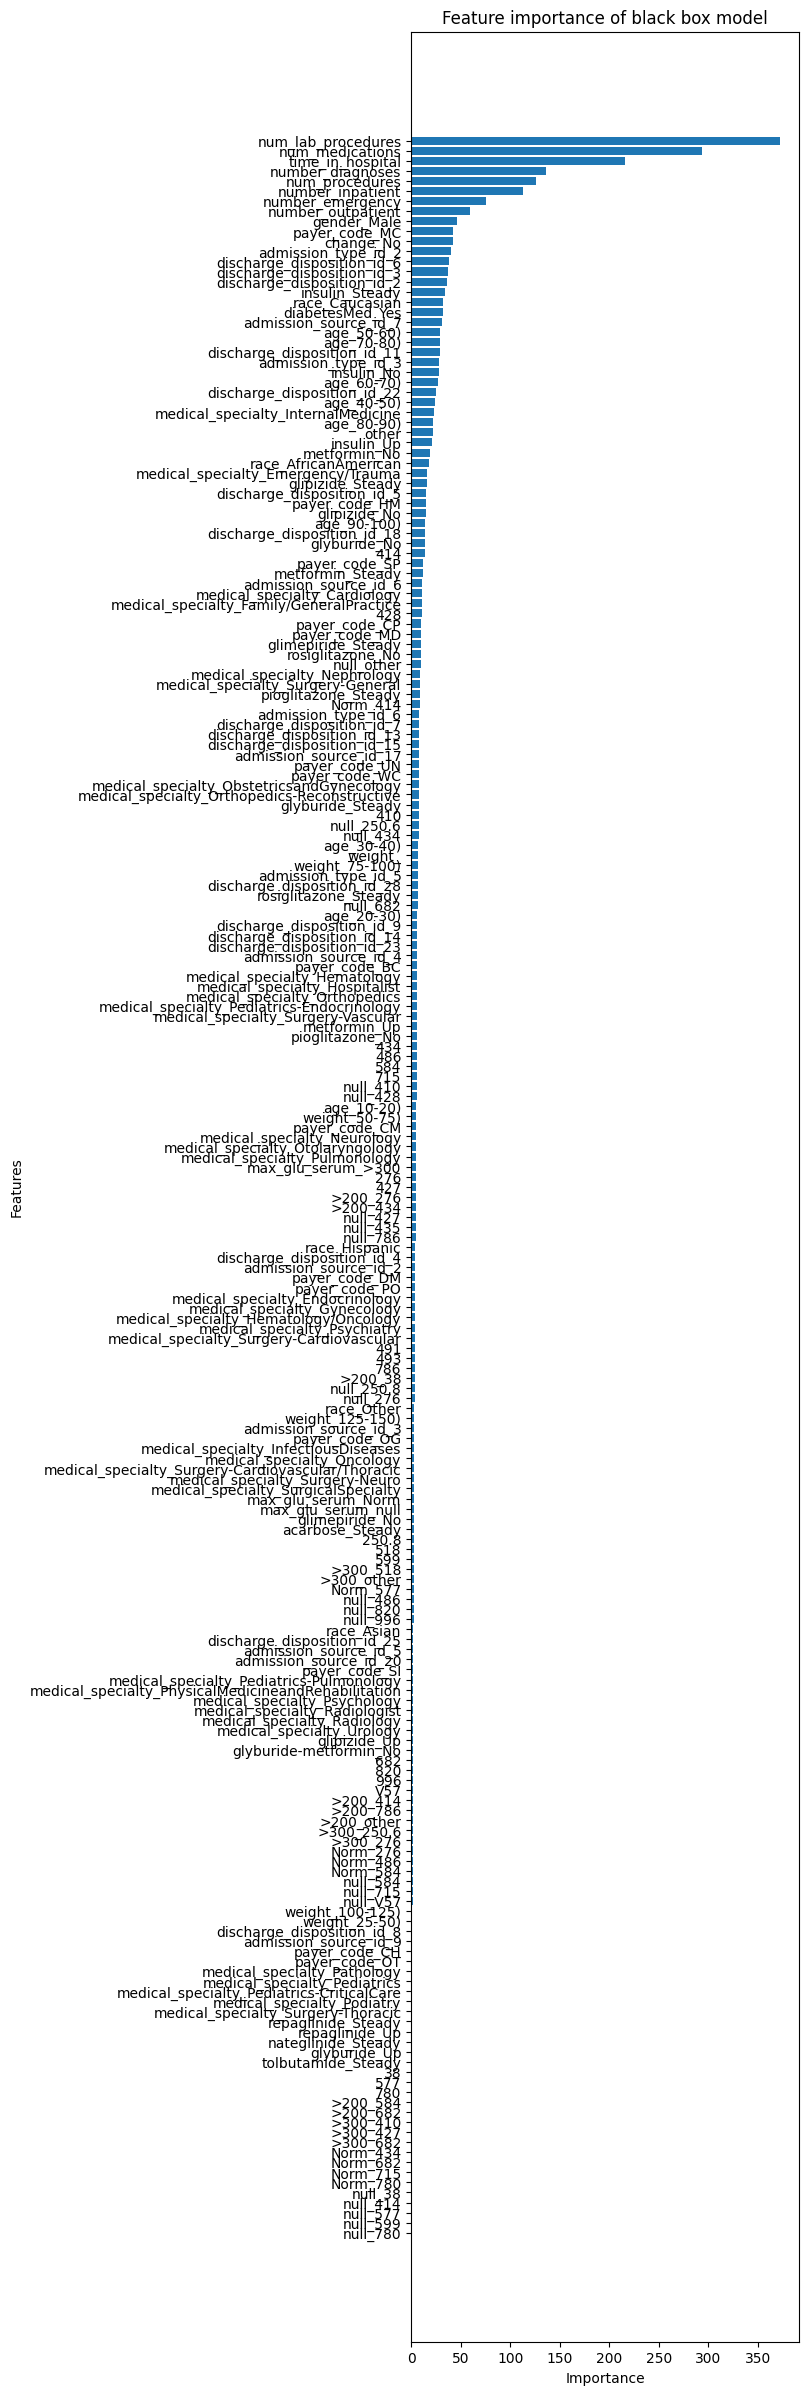

In [86]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming bb_xgb is your trained XGBoost model
booster = bb_xgb.get_booster()  # Get the booster object from XGBClassifier

feature_names = cols_clean  
booster.feature_names = feature_names

# Get feature importance
importance = booster.get_score(importance_type='weight', fmap='')

# Sort features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and their importance
features, values = zip(*sorted_importance)

# Create the plot manually
plt.figure(figsize=(5, 30))
plt.barh(range(len(features)), values, tick_label=features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.title('Feature importance of black box model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
